## Предсказание совершения покупки пользователем во время его сессии на сайте 

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [3]:
shoppers_data = pd.read_csv('../data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
print(shoppers_data.shape)

(12330, 18)


In [7]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [8]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


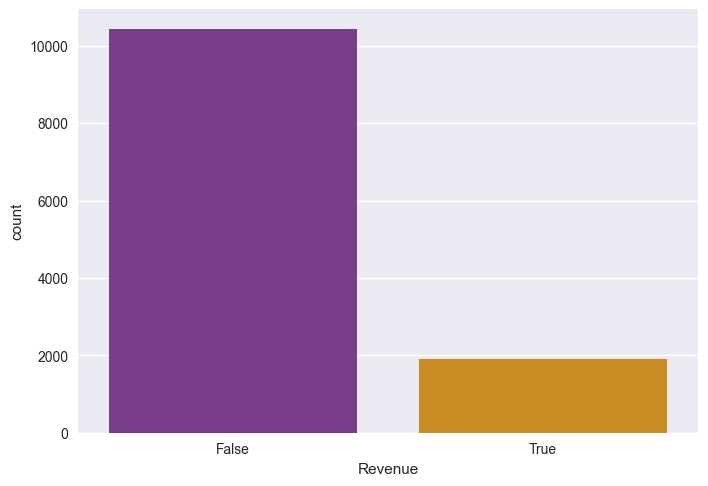

In [9]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Данные несбалансированы

In [13]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape[0], X_test.shape[0])

9864 2466


In [15]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


In [19]:
#Создаём объект кросс-валидатора KFold
kf = model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=rf, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([1.85193896, 1.60409951, 1.79996777, 1.51413107, 1.51813078]),
 'score_time': array([0.09394646, 0.0939455 , 0.07995486, 0.07597446, 0.07495737]),
 'test_score': array([0.64540338, 0.67636364, 0.65497076, 0.61904762, 0.65441176]),
 'train_score': array([1.        , 0.99959033, 1.        , 1.        , 1.        ])}

In [20]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 1.00
Valid k-fold mean accuracy: 0.65


Модель недообучена

Построим кривую обучения

In [21]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [25]:
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
        min_samples_leaf=5, #мин.количество объектов в листе
        random_state=42, #генератор случайных чисел
        n_estimators=200, #количество деревьев в лесу
        max_depth=5 #макс.глубина
    ),
    ensemble.RandomForestClassifier(
        min_samples_leaf=7, #мин.количество объектов в листе
        random_state=42, #генератор случайных чисел
        n_estimators=200, #количество деревьев в лесу
        max_depth=7 #макс.глубина
    ),
    ensemble.RandomForestClassifier(
        min_samples_leaf=12, #мин.количество объектов в листе
        random_state=42, #генератор случайных чисел
        n_estimators=200, #количество деревьев в лесу
        max_depth=12 #макс.глубина
    ),
]

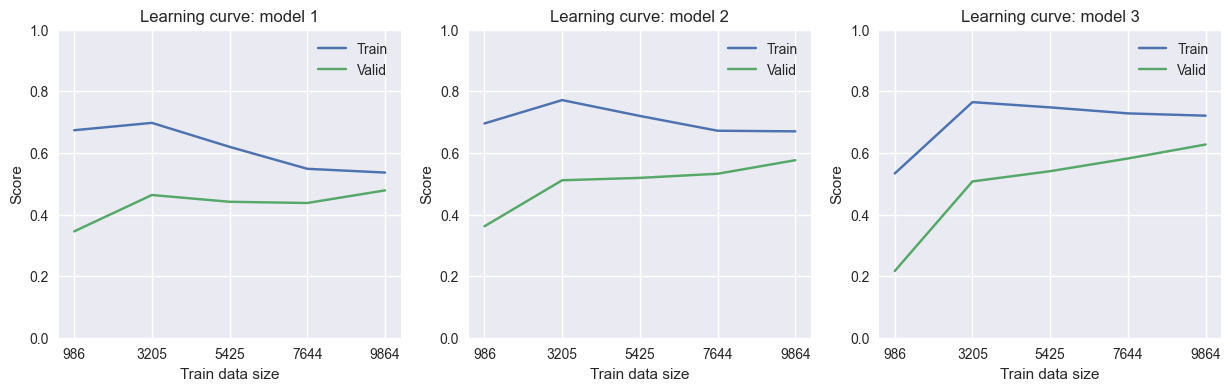

In [26]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')

Оптимальный вариант - модель 2

In [28]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    min_samples_leaf=5, #мин.количество объектов в листе
    random_state=42, #генератор случайных чисел
    n_estimators=200, #количество деревьев в лесу
    max_depth=7 #макс.глубина
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      8338
        True       0.86      0.57      0.68      1526

    accuracy                           0.92      9864
   macro avg       0.89      0.78      0.82      9864
weighted avg       0.92      0.92      0.91      9864

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Подберем порог вероятности

In [31]:
y_cv_proba_pred = model_selection.cross_val_predict(rf, X_train, y_train, cv=skf, method='predict_proba')

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

Best threshold = 0.36, F1-Score = 0.69


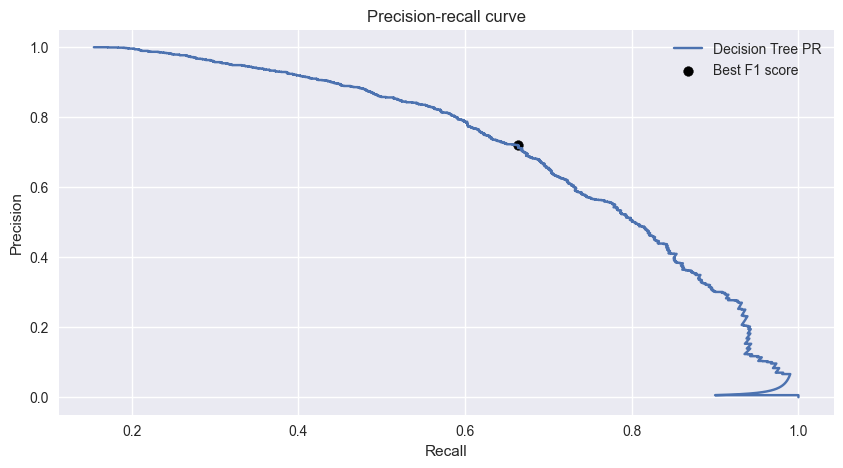

In [32]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [33]:
threshold_opt = 0.36

y_test_pred_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466



Благодаря подбору порога вероятности удалось повысить охват (recall) посетителей, которые совершат покупку, за счёт чего выросло значение F1-score.